# Mask, Generator, Analysis
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

It also analyzes the model and loss output for a given run.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
def load_data(im_width,im_height,inv_color_flag):
    train_data=np.load('training_set/lola_0_input_sample.npy').astype('float32')
    train_target=np.load('training_set/lola_0_targets_sample.npy').astype('float32')
    test_data=np.load('test_set/lola_1_input_sample.npy').astype('float32')
    test_target=np.load('test_set/lola_1_targets_sample.npy').astype('float32')
    print "Successfully loaded files locally."
    
    #norm data
    train_data /= 255
    test_data /= 255
    
    #increase contrast of data, inverse if flag=1
    low, hi = 0.1, 1                                                    #low, hi rescaling values
    for img in train_data:
        if inv_color_flag == 1:
            img[img > 0.] = 1. - img[img > 0.]
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

    for img in test_data:
        if inv_color_flag == 1:
            img[img > 0.] = 1. - img[img > 0.]
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling

    #reshape data to 3D array
    train_data = np.reshape(train_data, (len(train_data),im_width,im_height,1))
    test_data = np.reshape(test_data, (len(test_data),im_width,im_height,1))
    
    #norm train targets
    for i in range(len(train_target)):
        maxx = np.max(train_target[i])
        if maxx > 0:
            train_target[i] /= maxx

    #norm test targets
    for i in range(len(test_target)):
        maxx = np.max(test_target[i])
        if maxx > 0:
            test_target[i] /= maxx

    print "Successfully normalized data and target."
    return train_data, train_target, test_data, test_target

In [3]:
inv_color = 0
train_data, train_target, test_data, test_target = load_data(256,256,inv_color)

Successfully loaded files locally.
Successfully normalized data and target.


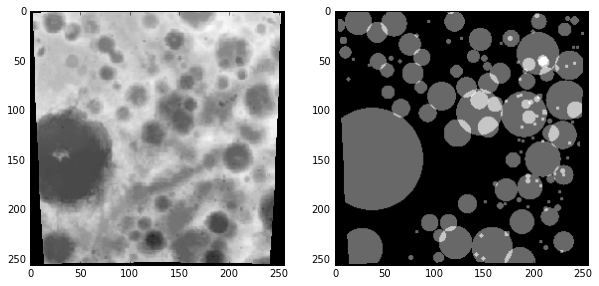

In [23]:
i=18
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 10])
ax1.imshow(test_data[i].reshape(256,256), origin='upper', cmap="Greys_r")
ax2.imshow(test_target[i], origin='upper', cmap="Greys_r")

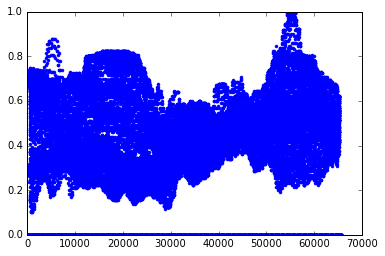

In [13]:
plt.plot(train_data[i].reshape(256*256,1), '.', label='ground truth pixel values')

## Load model and evaluate its performance

In [5]:
from keras.models import load_model

Using TensorFlow backend.


In [23]:
modelname = 'unet_s256_FL10_invc%d.h5'%inv_color
model = load_model('models/%s'%modelname)
#model.summary()

In [24]:
n,off=6,0
target = model.predict(test_data[off:(n+off)].astype('float32'))

In [25]:
err = np.sum((test_target[off:(n+off)] - target)**2) / (n*256*256)
err

0.035342030227184296

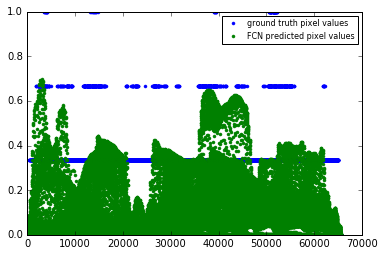

In [26]:
i=0
plt.plot(test_target[off+i].reshape(256*256,1), '.', label='ground truth pixel values')
plt.plot(target[i].reshape(256*256,1), '.', label='FCN predicted pixel values')
plt.legend(fontsize=8, numpoints=1)

In [ ]:
i=3

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12, 8])
ax1.imshow(test_data[off+i].reshape(256,256), origin='upper', cmap="Greys_r")
ax2.imshow(test_target[off+i], origin='upper', cmap="Greys_r")
ax3.imshow(target[i], origin='upper', cmap="Greys_r")
ax4.imshow(test_target[off+i] - target[i], origin='upper', cmap="Greys_r")
ax1.set_title('original image')
ax2.set_title('original target')
ax3.set_title('CNN target prediction')
diff = np.sum((test_target[i] - target[i])**2)/(256*256)
ax4.set_title('difference (mse) = %.3f'%diff)
plt.savefig('output_dir/%s_%d.png'%(modelname,i))

## Plot loss vs. epoch

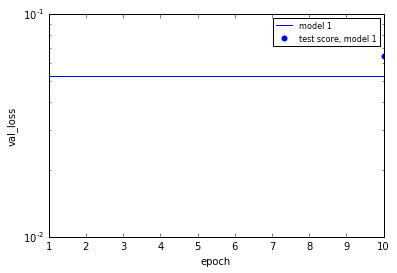

In [16]:
filename = 'output_dir/FCNforkskip_s256.txt'
#filename = 'models/good_models/FCNforkskip_imggen_lmbda0.0e+00.txt'

epoch_score, N_models = [], 0
lines = open(filename, 'r').readlines()
for line in lines:
    if "val_loss:" in line:
        epoch_score.append(float(line.split('val_loss:')[1]))
    elif "Test Score is" in line:
        N_models += 1
        test_score, n_epochs = float(line.split('Test Score is')[1]), len(epoch_score)
        p = plt.plot(np.arange(n_epochs)+1, epoch_score, label='model %d'%N_models)
        plt.plot(n_epochs, test_score, 'o', color=p[0].get_color(), mew=0, label='test score, model %d'%N_models)
        plt.legend(fontsize=8, numpoints=1)
        epoch_score = []

plt.plot(np.arange(len(epoch_score))+1, epoch_score)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.yscale('log')